In [1]:
%pylab inline
%matplotlib inline
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/Users/Argen/Documents/MAS/R&D/Code/pgm'])

Populating the interactive namespace from numpy and matplotlib
Python 2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)] on darwin


In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

In [3]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
from pgm.nodes.chance import Chance
from pgm.nodes.decision import Decision
from pgm.nodes.utility import Utility

# Tools

In [6]:
def node_types(graph):
    chance = []
    decision = []
    utility = []
    
    for n in graph:
        if graph.node[n]['type'] == 'chance':
            chance.append(n)
        elif graph.node[n]['type'] == 'decision':
            decision.append(n)
        elif graph.node[n]['type'] == 'utility':
            utility.append(n)
    
    nodes = {'chance':chance, 'decision':decision, 'utility':utility}
    
    return nodes

To do:
-----
[ ] Plot edges type (nx.draw_networkx_edges(G, pos, edgelist=edges, width=6, alpha=0.5, edge_color='b', style='dashed')

In [7]:
def draw_graph(graph, pos=None, size=600, alpha=0.9, show=False, save=False):
    # 's' = square
    # 'D' = diamond
    # 'o' = circle

    title = graph.graph['title']

    plt.figure()
    plt.axis('off')

    if pos==None:
        p = nx.graphviz_layout(graph, prog='dot')
    else:
        p=pos

    node_dict = node_types(graph)
    chance, decision, utility = node_dict.get('chance'), node_dict.get('decision'), node_dict.get('utility')
    # print len(chance), len(decision), len(utility)
    
        
    if len(chance) > 0:
        nx.draw_networkx_nodes(graph, p, nodelist=chance, node_size=size, node_shape='o', alpha=alpha, node_color='w')
    if len(decision) > 0:
        nx.draw_networkx_nodes(graph, p, nodelist=decision, node_size=size, node_shape='s',alpha=alpha, node_color='g')
    if len(utility) > 0:
        nx.draw_networkx_nodes(graph, p, nodelist=utility, node_size=size, node_shape='D', alpha=alpha, node_color='r')

    nx.draw_networkx_edges(graph, pos=p)
    nx.draw_networkx_labels(graph, pos=p)

    if save:
        nx.write_dot(graph, title + '.dot')
        plt.savefig(title + '.png')

    if show:
        plt.show()

# Influence Diagram

## Definition

In [8]:
a = Chance('A')
b = Chance('B')
c = Chance('C')
d = Chance('D')
e = Chance('E')
f = Chance('F')
g = Chance('G')
h = Chance('H')
i = Chance('I')
j = Chance('J')
k = Chance('K')
l = Chance('L')

d1 = Decision('D1')
d2 = Decision('D2')
d3 = Decision('D3')
d4 = Decision('D4')

v1 = Utility('V1')
v2 = Utility('V2')
v3 = Utility('V3')
v4 = Utility('V4')

chance = [a, b, c, d, e, f, g, h, i, j, k, l]
decision = [d1, d2, d3, d4]
utility = [v1, v2, v3, v4]

edges = [(a, c), (b, c), (b, d1), (b, d), (d1, v1), (d1, d),
         (c, e), (d, e), (d, f), (e, g), (e, d2), (f, d2), (f, h),
         (g, d4), (g, i), (d2, i), (d2, d3), (h, k), (h, j), (d3, k), (d3, v2), (d3, d4),
         (d4, l), (i, l), (j, v3), (k, v3), (l, v4)]
nodes = []
nodes.extend(chance)
nodes.extend(decision)
nodes.extend(utility)

In [9]:
net = nx.DiGraph(title='influence_diagram')

id_nodes = [n.node for n in nodes]
id_edges = [(e[0].name, e[1].name) for e in edges]

net.add_nodes_from(id_nodes)
net.add_edges_from(id_edges)

node_dict = node_types(net)
chance, decision, utility = node_dict.get('chance'), node_dict.get('decision'), node_dict.get('utility')

print chance, decision, utility
print id_nodes
print id_edges

['A', 'C', 'B', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'J', 'L'] ['D4', 'D2', 'D3', 'D1'] ['V1', 'V2', 'V3', 'V4']
[('A', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT A>}), ('B', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT B>}), ('C', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT C>}), ('D', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT D>}), ('E', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT E>}), ('F', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT F>}), ('G', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT G>}), ('H', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT H>}), ('I', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT I>}), ('J', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT J>}), ('K', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT K>}), ('L', {'domain': ['T', 'F'], 'type': 'chance', 'jpt': <CPT L>}), ('D1', {'domain': ['d1', 'd2'], 'type': 'decision'}), ('D2', {'domain': ['d1', 'd2'], 'type': 'decision'}), 

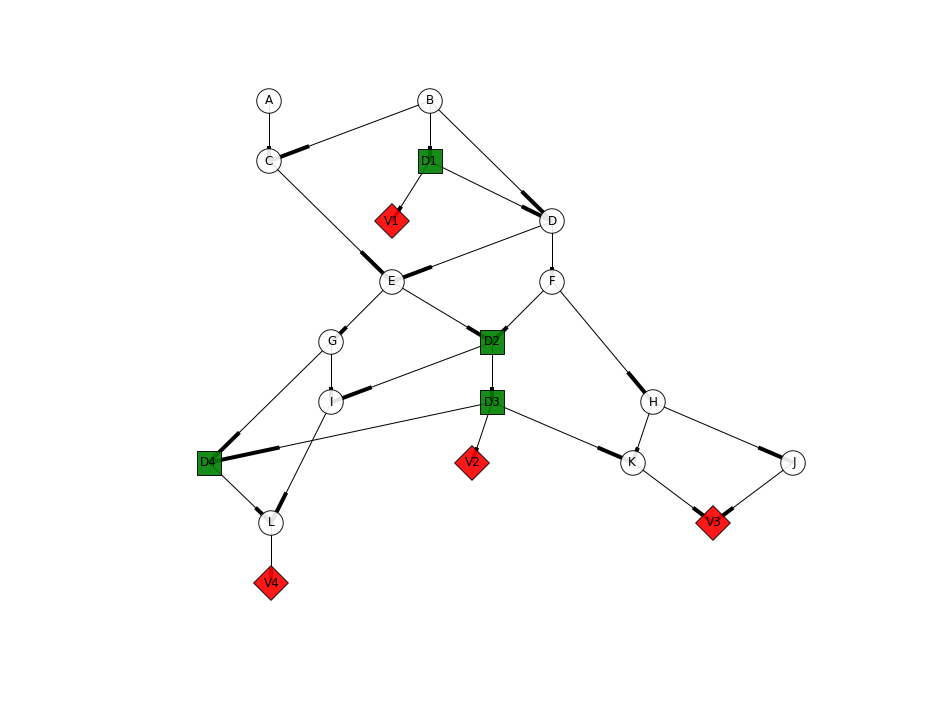

In [10]:
pos = nx.graphviz_layout(net, prog='dot')
draw_graph(net, pos)

### Validation

In [11]:
# TODO: Check cpt and ut size

def validate(graph, verbose=False):
        for n in graph.nodes():
            if verbose:
                print '----------'
                # print n
                # print 'Parents: ' + graph.predecessors(n).__str__()
                # print 'Children: ' + graph.successors(n).__str__()
                print '%s -> %s -> %s' %(graph.predecessors(n).__str__(), n, graph.successors(n).__str__())
                if not graph.is_directed():
                    print 'Neighbors: ' + graph.neighbors(n).__str__()
                print '----------'
                # print
        print 'ID is validated.'
        
validate(net, True)

----------
[] -> A -> ['C']
----------
----------
['A', 'B'] -> C -> ['E']
----------
----------
[] -> B -> ['C', 'D', 'D1']
----------
----------
['C', 'D'] -> E -> ['D2', 'G']
----------
----------
['B', 'D1'] -> D -> ['E', 'F']
----------
----------
['E'] -> G -> ['I', 'D4']
----------
----------
['D'] -> F -> ['H', 'D2']
----------
----------
['D2', 'G'] -> I -> ['L']
----------
----------
['F'] -> H -> ['K', 'J']
----------
----------
['H', 'D3'] -> K -> ['V3']
----------
----------
['H'] -> J -> ['V3']
----------
----------
['I', 'D4'] -> L -> ['V4']
----------
----------
['D1'] -> V1 -> []
----------
----------
['D3'] -> V2 -> []
----------
----------
['K', 'J'] -> V3 -> []
----------
----------
['L'] -> V4 -> []
----------
----------
['D3', 'G'] -> D4 -> ['L']
----------
----------
['E', 'F'] -> D2 -> ['I', 'D3']
----------
----------
['D2'] -> D3 -> ['D4', 'K', 'V2']
----------
----------
['B'] -> D1 -> ['V1', 'D']
----------
ID is validated.


## Partial Temporal Order

In [12]:
des = []
observed = []

windows = {}
order = {}


# Sort decision orders
for d in decision:
    pred = list(set(nx.ancestors(net, d)) & set(decision))
    des.insert(len(pred), d)
    n = len(pred) * 2
    parents = net.predecessors(d)
    observed.extend(parents)
    windows[n + 1] = [d]
    windows[n] = list(set(parents).difference(set(decision)))
    order[d] = n + 1
    order.update({p: n for p in parents})
n = max(order.values()) + 1
unobserved = list(set(chance).difference(observed))
order.update({u: n for u in unobserved})
windows.update({n: unobserved})
print 'Order: ', order
print 'Windows: ', windows

Order:  {'A': 8, 'C': 8, 'B': 0, 'E': 2, 'D': 8, 'G': 6, 'F': 2, 'I': 8, 'H': 8, 'K': 8, 'J': 8, 'L': 8, 'D4': 7, 'D2': 4, 'D3': 5, 'D1': 1}
Windows:  {0: ['B'], 1: ['D1'], 2: ['E', 'F'], 3: ['D2'], 4: [], 5: ['D3'], 6: ['G'], 7: ['D4'], 8: ['A', 'C', 'D', 'I', 'H', 'K', 'J', 'L']}


##### Function

### Moralize

In [13]:
def moralize(digraph):
    G = digraph.copy()
    G.graph['title']= 'moral_steps'
    
    nd = node_types(G)
    c, d, u = nd.get('chance'), nd.get('decision'), nd.get('utility')
    
    # Remove information links
    for n in d:
        for p in digraph.predecessors(n):
            G.remove_edge(p, n)
            
    # Add moral links
    moral_edges = []
    for n in digraph.nodes_iter():
        arcs = list(combinations(G.predecessors(n), 2))
        for a in arcs:
            if a in digraph.edges():
                moral_edges.append(a)
            elif a[::-1] in digraph.edges():
                moral_edges.append(a[::-1])
            else:
                moral_edges.append(a)
            
    G.add_edges_from(moral_edges)
    
    # Convert to undirected graph
    moralgraph = G.to_undirected()
    moralgraph.graph['title']='moral_graph'
        
    # Remove utility nodes
    moralgraph.remove_nodes_from(utility)
    return moralgraph

### Evidence

### Triangulated Graph

In [14]:
def triangulate(ugraph):
    t = ugraph.copy()
    fill_ins = []
    cliques = []
    
    for n, w in sorted(windows.items(), reverse=True):
        size = {}
        for i in w:
            size[i] = sz(fa(t, i))
    
        while size != {}:
            # Remove simplicial nodes
            simplicial = [n for n in size if is_simplicial(t, n)]
    
            if len(simplicial) > 0:
                # print len(size), simplicial, t.nodes()
    
                for n in simplicial:
                    f = fa(t,n)
                    subset = filter(lambda x: set(f)< set(x), cliques)
                    if subset == []:
                        cliques.append(f)
                    t.remove_node(n)
                    size.pop(n)
                # print t.nodes()
            else:
                # print len(size),t.nodes()
                for i in size:
                    size[i] = sz(fa(t, i))
    
                if len(size) > 0:
                    candidate = min(size, key=size.get)
                    # s = t.subgraph(fa(t, candidate))
                    neigh = nb(t, candidate)
    
                    # print list(combinations(n, 2))
                    fill = []
                    # TODO: Algo esta mal con los cliques
                    for e1, e2 in list(combinations(neigh, 2)):
                        if not t.has_edge(e1, e2) or not t.has_edge(e2, e1):
                            # print candidate, e1, e2
                            t.add_edge(e1, e2)
                            fill_ins.append((e1, e2))
                            
                    f = fa(t,candidate)
                    subset = filter(lambda x: set(f)< set(x), cliques)
                    if subset == []:
                        cliques.append(f)
                    t.remove_node(candidate)
                    size.pop(candidate)
                    # print candidate, t.nodes()
    
            # draw_graph(t, pos_ex)
    triangulated = ugraph.copy()
    triangulated.add_edges_from(fill_ins)
    return triangulated

## Junction Tree

## Probability Propagation